In [334]:
import cobra
from cobra.io import read_sbml_model
from pprint import pprint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from cobra.medium import minimal_medium

from process_bigraph import Composite
from process_bigraph import ProcessTypes
from process_bigraph.emitter import gather_emitter_results

from cdFBA import register_types
from cdFBA.processes.dfba import dFBA, UpdateEnvironment, StaticConcentration, Injector, WaveFunction

from cdFBA.utils import make_cdfba_composite, get_injector_spec, get_wave_spec, get_static_spec, set_concentration, set_kinetics, get_exchanges

from in_silico_functions.carbon_sources import (load, met_info, find_fluxes, make_fluxes_dict, make_dict,main, classify_met)

In [335]:
def get_mini_medium(model, target_growth=10e-4):
    ## make a copy of the model
    try_model = model.copy()

    ## compute the minimum media neccessary for growth at targeted_growth
    mini_growth = minimal_medium(try_model, target_growth, minimize_components=10, open_exchanges=True)

    ## set minimal medium
    mini_medium = {}
    for i in mini_growth.index:
        mini_medium[i] = try_model.medium[i]

    ## get all other metabolites that can be added to the medium
    additional_medium = try_model.medium
    for i in mini_medium.keys():
        del additional_medium[i]
    return mini_medium, additional_medium

In [336]:
# Load models

gut_models = {
        "B_thetaiotaomicron": "/Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/sbml_mini/Bacteroides_thetaiotaomicron_VPI_5482.xml",
        "E_rectale": "/Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/sbml_mini/Eubacterium_rectale_ATCC_33656.xml"
    }

models = {k: read_sbml_model(v) for k, v in gut_models.items()}

BT = models["B_thetaiotaomicron"]
ER = models["E_rectale"]

In [337]:
# Create minimal media
medium_bt = get_mini_medium(BT)[0]
medium_bt["EX_MGlcn175_rl(e)"] = 0.00
medium_bt["EX_cholate(e)"] = 0.00 # want bt to consume cholate and produce acetate for er to eat, give it nothing so that it has to get it from shared environment
# medium_bt["EX_hspg(e)"] = 0.00  # kill switch for bt

BT.medium = medium_bt

medium_er = get_mini_medium(ER)[0]
medium_er["EX_pullulan1200(e)"] = 10e-6 # if this number is small enough, er produces more butyrate
medium_er["EX_ac(e)"] = 0 # want ER to consume acetate from bt, so don't give it acetate so that it has to get it from bt
# I am seeing that organism consumes acetate and pullulan together, but does not consume acetate unless there is enough pullulan in media.
# w/o acetate, uses more pullulan1200, w/acetate, consumes both
ER.medium = medium_er

In [338]:
# write minimal media files, view media
cobra.io.write_sbml_model(BT, "/in_silico_scripts/sbml_mini/bt.xml")
bt_try = read_sbml_model("/in_silico_scripts/sbml_mini/bt.xml")
bt_try.optimize()
print(bt_try.summary())

cobra.io.write_sbml_model(ER, "/in_silico_scripts/sbml_mini/er.xml")
er_try = read_sbml_model("/in_silico_scripts/sbml_mini/er.xml")
er_try.optimize()
print(er_try.summary())

Objective
1.0 biomass345 = 0.0

Uptake
------
Empty DataFrame
Columns: [Metabolite, Reaction, Flux, C-Number, C-Flux]
Index: []

Secretion
---------
Empty DataFrame
Columns: [Metabolite, Reaction, Flux, C-Number, C-Flux]
Index: []

Objective
1.0 biomass205 = 0.0006087523917212463

Uptake
------
     Metabolite           Reaction      Flux  C-Number C-Flux
     Lcystin[e]      EX_Lcystin(e) 2.459E-05         6  0.17%
      alagln[e]       EX_alagln(e) 0.0006265         8  5.64%
      alahis[e]       EX_alahis(e) 4.989E-05         9  0.51%
      alathr[e]       EX_alathr(e)  0.000329         7  2.59%
         ca2[e]          EX_ca2(e) 4.833E-06         0  0.00%
          cl[e]           EX_cl(e) 4.833E-06         0  0.00%
     cobalt2[e]      EX_cobalt2(e) 4.833E-06         0  0.00%
         cu2[e]          EX_cu2(e) 4.833E-06         0  0.00%
         fe2[e]          EX_fe2(e)  1.45E-05         0  0.00%
         fe3[e]          EX_fe3(e) 4.833E-06         0  0.00%
         fol[e]       

In [339]:
gut_models_mini = {
        "B_thetaiotaomicron": "/Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/in_silico_scripts/sbml_mini/bt.xml",
        "E_rectale": "/Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/in_silico_scripts/sbml_mini/er.xml"
    }

models = {k: read_sbml_model(v) for k, v in gut_models_mini.items()}

In [340]:
exchanges = ['EX_ac(e)', 'EX_but(e)', 'EX_ch4(e)','EX_cholate(e)', 'EX_pullulan1200(e)'] # acetate, butyrate, H2, methane, cholate, pullulan

volume = 2

# dFBA model
spec = make_cdfba_composite(gut_models_mini, medium_type=None, exchanges=exchanges, volume=volume, interval=0.1)

pprint(spec)

{'Shared Environment': {'concentrations': {'B_thetaiotaomicron': 0.25,
                                           'Cholate': 10.0,
                                           'E_rectale': 0.25,
                                           'acetate': 10.0,
                                           'butyrate': 10.0,
                                           'pullulan (n=1200 repeat units, alpha-1,4 and alph-1,6 bounds)': 10.0},
                        'counts': {'B_thetaiotaomicron': 0.5,
                                   'Cholate': 20,
                                   'E_rectale': 0.5,
                                   'acetate': 20,
                                   'butyrate': 20,
                                   'pullulan (n=1200 repeat units, alpha-1,4 and alph-1,6 bounds)': 20},
                        'volume': 2},
 'Species': {'B_thetaiotaomicron': {'_type': 'process',
                                    'address': 'local:dFBA',
                                    'config':

In [341]:
#Set reaction bounds (constrain bounds here to make it so that the exchange reactions can't take place)
spec['Species']['B_thetaiotaomicron']['config']['bounds'] = {
            "EX_o2(e)": {"lower": -2, "upper": None},
            "DM_atp_c_": {"lower": 1, "upper": 1},
        }
spec['Species']['E_rectale']['config']['bounds'] = {
            "EX_o2(e)": {"lower": -2, "upper": None},
            "DM_atp_c_": {"lower": 1, "upper": 1}
        }

In [342]:
#set external substrate concentrations
concentrations = {      # zero polysaccharides (pectin and cholate) to stop b theta from growing, limit acetate so that it has to come from keystone species
    'acetate': 0,
    'butyrate': 0,
    'Cholate' : 0, # give cholate so that BT can grow and produce acetate for ER
    'pullulan (n=1200 repeat units, alpha-1,4 and alph-1,6 bounds)' : 10

}
set_concentration(spec, concentrations)

In [343]:
#set kinetics
kinetics = {
    'acetate': (0.5, 5), # reduce km, increase Vmax
    'butyrate': (0.5, 5),
    'Cholate': (0.5, 5),
    'pullulan (n=1200 repeat units, alpha-1,4 and alph-1,6 bounds)' : (0.5, 5)
}
for species in gut_models.keys():
    set_kinetics(species, spec, kinetics)
pprint(spec)

{'Shared Environment': {'concentrations': {'B_thetaiotaomicron': 0.25,
                                           'Cholate': 0,
                                           'E_rectale': 0.25,
                                           'acetate': 0,
                                           'butyrate': 0,
                                           'pullulan (n=1200 repeat units, alpha-1,4 and alph-1,6 bounds)': 10},
                        'counts': {'B_thetaiotaomicron': 0.5,
                                   'Cholate': 0,
                                   'E_rectale': 0.5,
                                   'acetate': 0,
                                   'butyrate': 0,
                                   'pullulan (n=1200 repeat units, alpha-1,4 and alph-1,6 bounds)': 20},
                        'volume': 2},
 'Species': {'B_thetaiotaomicron': {'_type': 'process',
                                    'address': 'local:dFBA',
                                    'config': {'bounds': {'

In [344]:
#set emitter specs
spec['emitter'] = {
        "_type": "step",
        "address": "local:ram-emitter",
        "config": {
            "emit": {
                "shared_environment": "any",
                "global_time": "any",
            }
        },
        "inputs": {
            "shared_environment": ["Shared Environment"],
            "global_time": ["global_time"]
        }
    }

In [345]:
#create the core object
core = ProcessTypes()
#register data types
core = register_types(core)
#register all processes and steps
core.register_process('dFBA', dFBA)
core.register_process('UpdateEnvironment', UpdateEnvironment)
core.register_process('StaticConcentration', StaticConcentration)
core.register_process('WaveFunction', WaveFunction)
core.register_process('Injector', Injector)

In [346]:
# KO all reactions for one species

In [347]:
sim = Composite({
        "state": spec,
        },
        core=core
    )

In [348]:
#run simulation
sim.run(20)

In [349]:
#gather results
results = gather_emitter_results(sim)[('emitter',)]

In [350]:
#extract time-series data
timepoints = []
for timepoint in results:
    time = timepoint.pop('global_time')
    timepoints.append(time)
env = [timepoint['shared_environment']['concentrations'] for timepoint in results]
env_combined = {}
for d in env:
    for key, value in d.items():
        if key not in env_combined:
            env_combined[key] = []
        env_combined[key].append(value)

In [351]:
results

[{'shared_environment': {'concentrations': {'Cholate': 0.0,
    'acetate': 0.0,
    'butyrate': 0.0,
    'pullulan (n=1200 repeat units, alpha-1,4 and alph-1,6 bounds)': 10.0,
    'B_thetaiotaomicron': 0.25,
    'E_rectale': 0.25},
   'counts': {'Cholate': 0.0,
    'acetate': 0.0,
    'butyrate': 0.0,
    'pullulan (n=1200 repeat units, alpha-1,4 and alph-1,6 bounds)': 20.0,
    'B_thetaiotaomicron': 0.5,
    'E_rectale': 0.5},
   'volume': 2.0}},
 {'shared_environment': {'counts': {'Cholate': 0.0,
    'acetate': 0.0,
    'butyrate': 0.0,
    'pullulan (n=1200 repeat units, alpha-1,4 and alph-1,6 bounds)': 20.0,
    'B_thetaiotaomicron': 0.5,
    'E_rectale': 0.5},
   'concentrations': {'Cholate': 0.0,
    'acetate': 0.0,
    'butyrate': 0.0,
    'pullulan (n=1200 repeat units, alpha-1,4 and alph-1,6 bounds)': 10.0,
    'B_thetaiotaomicron': 0.25,
    'E_rectale': 0.25},
   'volume': 2.0}},
 {'shared_environment': {'counts': {'Cholate': np.float64(0.0),
    'acetate': np.float64(0.0167

/var/folders/83/2fn1zt090m956h7gkwysmm980000gn/T/ipykernel_12097/2007386906.py:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 10e3)


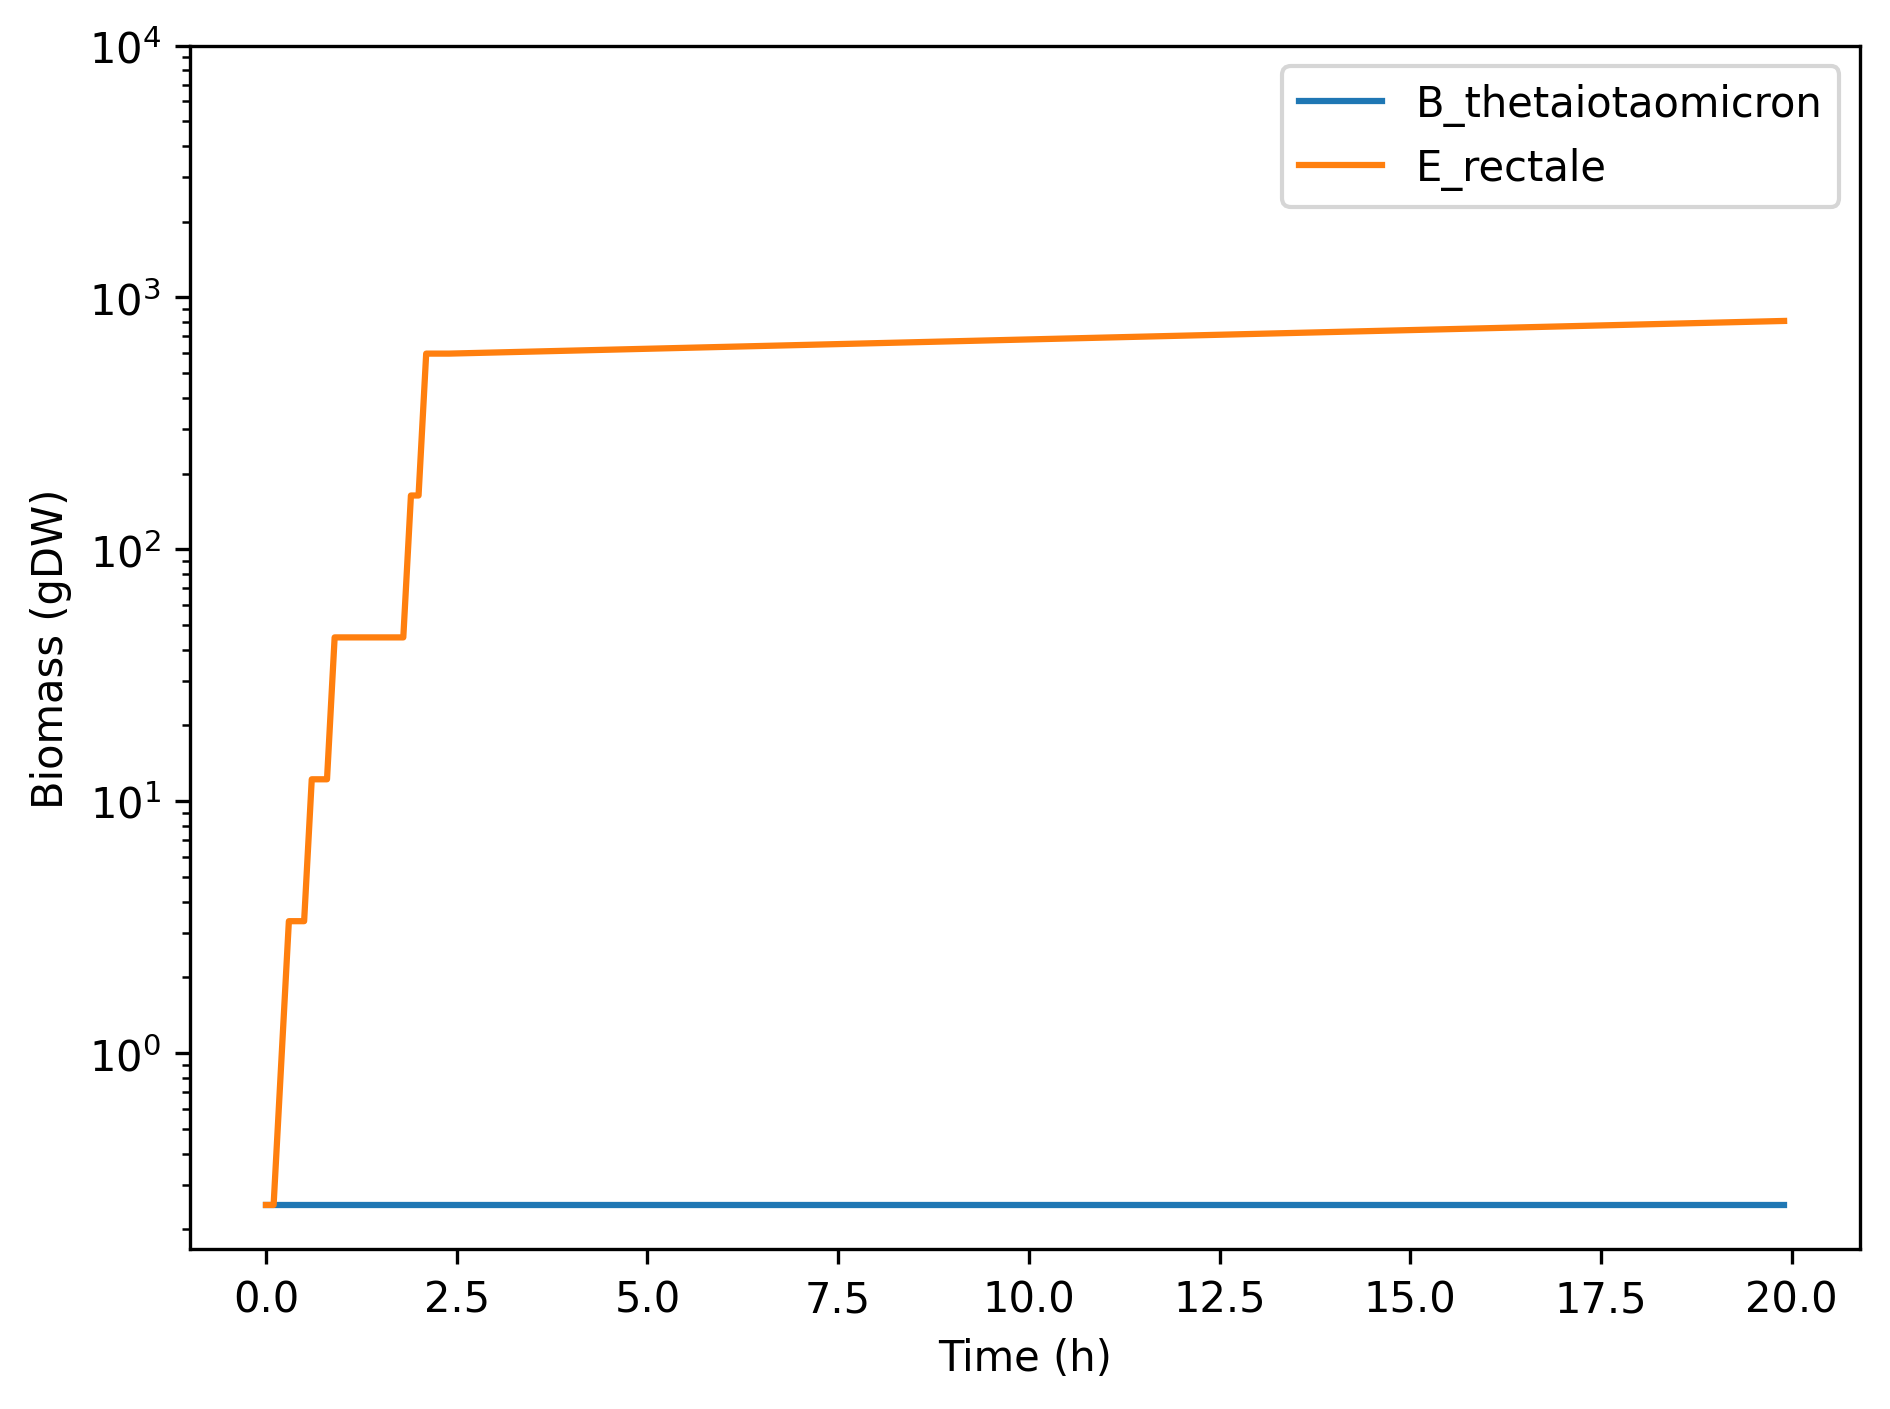

In [354]:
#plot results for biomass
fig, ax = plt.subplots(dpi=300)
for key, value in env_combined.items():
    if key not in ['acetate', 'butyrate', 'Cholate', 'pullulan (n=1200 repeat units, alpha-1,4 and alph-1,6 bounds)']:
        ax.plot(timepoints, env_combined[key], label=key)
        ax.set_yscale('log')
plt.ylim(0, 10e3)
plt.xlabel('Time (h)')
plt.ylabel('Biomass (gDW)')
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/83/2fn1zt090m956h7gkwysmm980000gn/T/ipykernel_12097/115205709.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


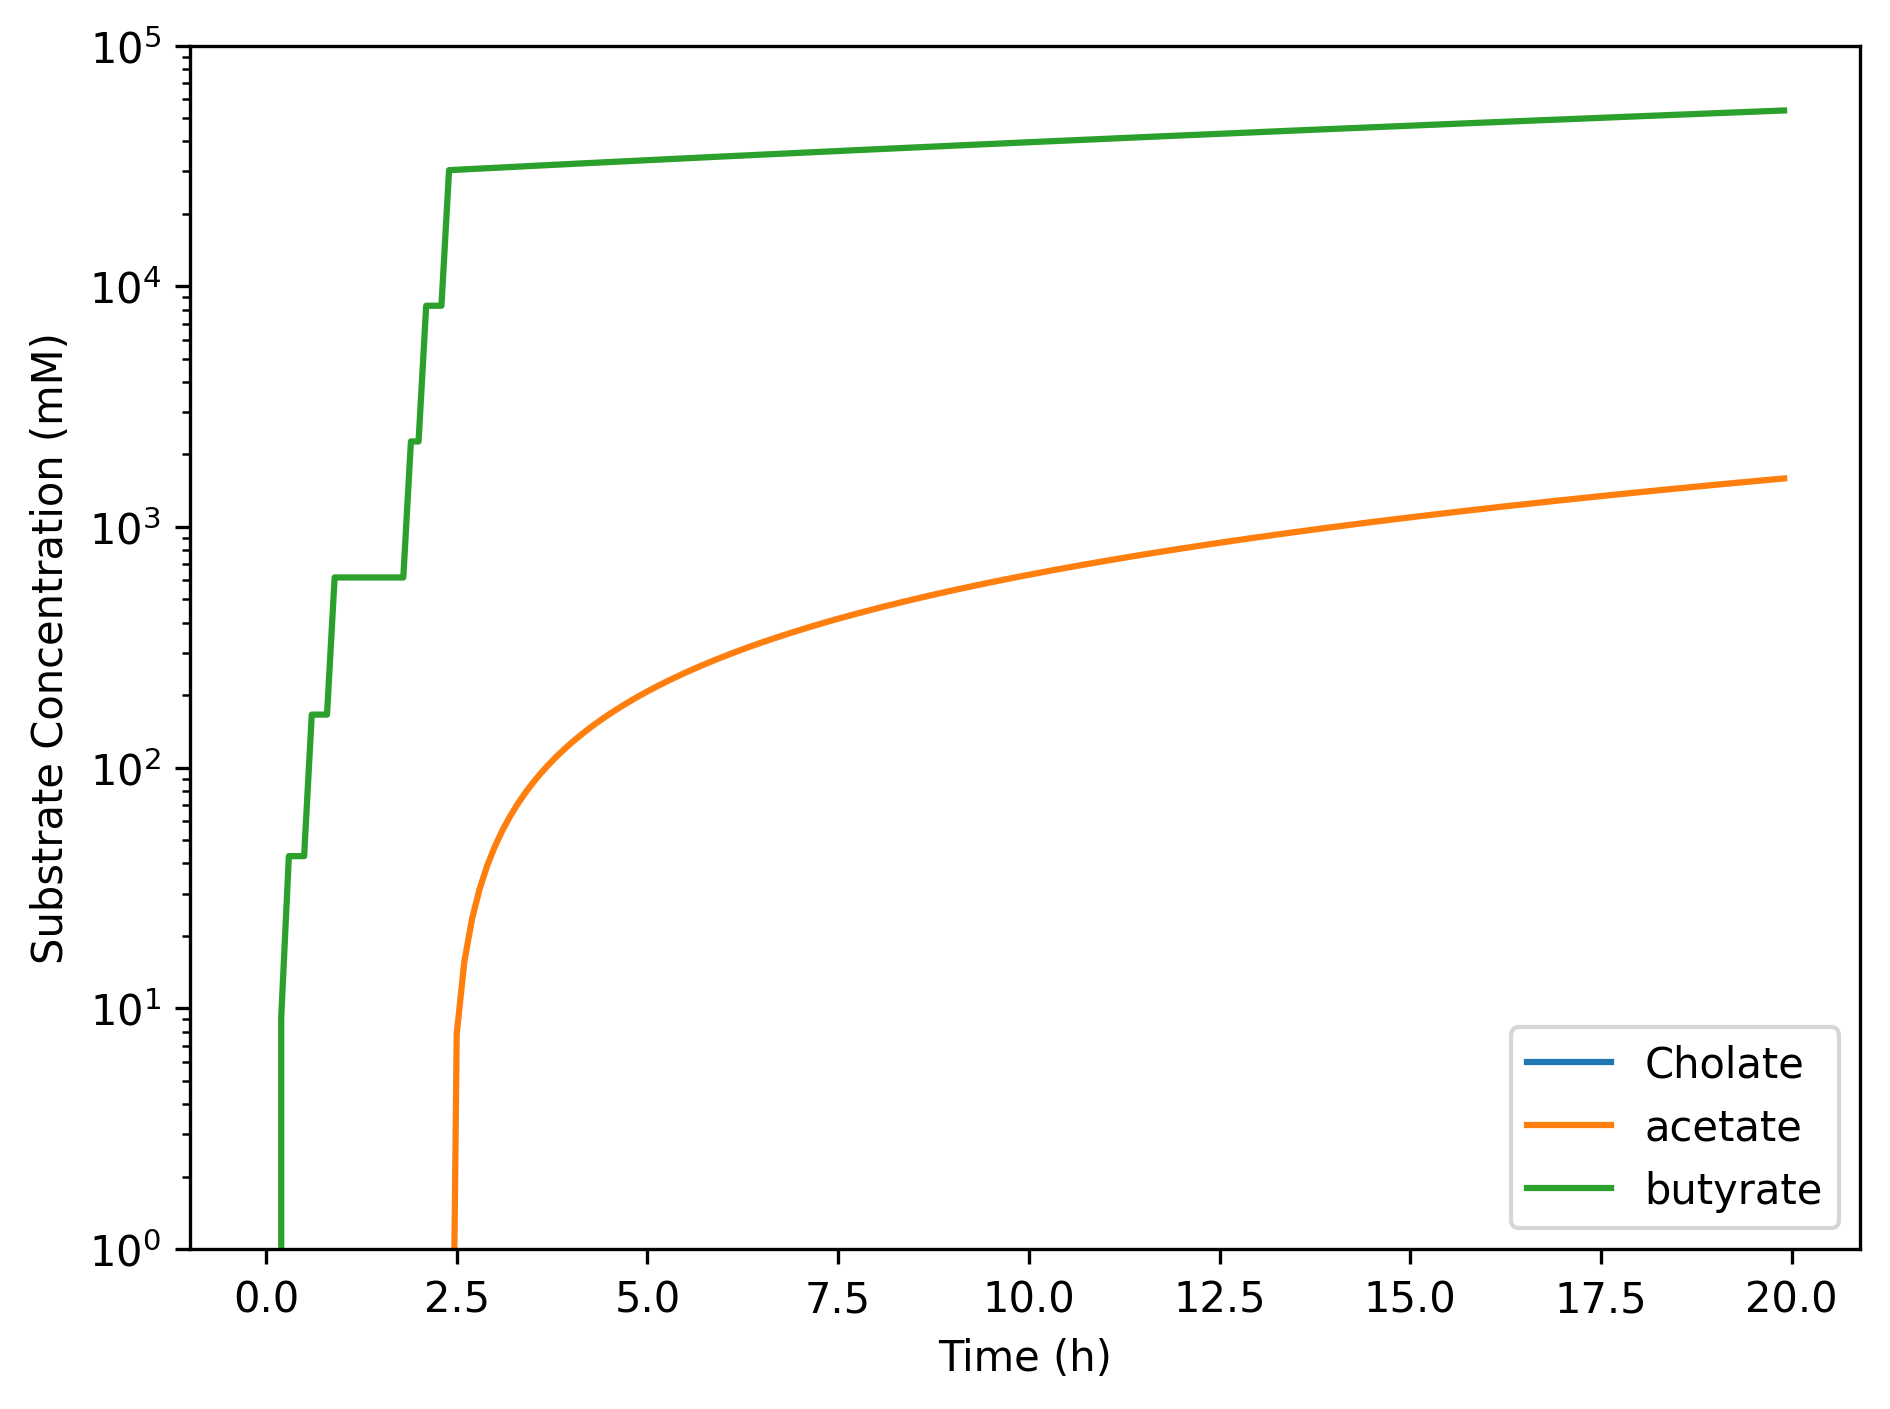

In [353]:
#plot substrates
fig, ax = plt.subplots(dpi=300)
for key, value in env_combined.items():
    if key in ['acetate', 'Cholate', 'butyrate']:
        ax.plot(timepoints, env_combined[key], label=key)
        ax.set_yscale('log')
plt.ylim(1, 10e4)
plt.xlabel('Time (h)')
plt.ylabel('Substrate Concentration (mM)')
plt.legend()
plt.tight_layout()
plt.show()